In [1]:
import numpy as np
import matplotlib.pyplot as plt
import freud
import signac
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import scipy
from scipy import signal
import time
import os
from scipy.stats import linregress
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [5]:
data_path = "/home/erjank_project/ptb7-project/workspace"

project = signac.get_project(data_path)
#for job in project:
#    print(job)

In [14]:
state_dict = {"molecule": "PTB7_10mer_smiles",
              "size":"medium",
              "process":"quench",
              "density": 0.9,
              "kT_reduced": 1.7}

job_list = project.find_jobs(state_dict)

In [15]:
for job in job_list:
    rdf_path = job.fn("trajectory.gsd")
    print(job)
    temp = job.sp.kT_reduced
    print(temp)

fe36ee4052a01cae041ef5988477de10
1.7


In [16]:
for job in job_list:
    temp = job.sp.kT_reduced
    print(temp)

1.7


In [11]:
def frame_get_type_position(gsdfile, typename, frame=-1):
    with gsd.hoomd.open(name=gsdfile, mode='rb') as f:
        snap = f[frame]
    typepos = snap.particles.position[
            snap.particles.typeid == snap.particles.types.index(typename)
            ]
    return typepos
def snap_bond_graph(snap):
    bond_graph = csr_matrix(
        (np.ones(snap.bonds.N), (snap.bonds.group[:, 0], snap.bonds.group[:, 1])),
        shape=(snap.particles.N, snap.particles.N),
    )
    n_components, labels = connected_components(csgraph=bond_graph, directed=False)
    return labels
def gsd_rdf(
    rdf_path,
    A_name,
    B_name,
    start=0,
    stop=None,
    rmax=None,
    rmin=0,
    bins=50,
    exclude_bonded=True):
    with gsd.hoomd.open(rdf_path) as t:
        snap = t[0]
        if rmax is None:
            rmax = max(snap.configuration.box[:3]) * 0.45
        rdf = freud.density.RDF(bins=bins, r_max=rmax, r_min=rmin)
        type_A = snap.particles.typeid == snap.particles.types.index(A_name)
        type_B = snap.particles.typeid == snap.particles.types.index(B_name)
        if exclude_bonded:
            molecules = snap_bond_graph(snap)
            molecules_A = molecules[type_A]
            molecules_B = molecules[type_B]
        for snap in t[start:stop]:
            A_pos = snap.particles.position[type_A]
            if A_name != B_name:
                B_pos = snap.particles.position[type_B]
            else:
                B_pos = A_pos
            box = snap.configuration.box
            system = (box, A_pos)
            aq = freud.locality.AABBQuery.from_system(system)
            nlist = aq.query(B_pos, {"r_max": rmax}).toNeighborList()
            if exclude_bonded:
                nlist.filter(molecules_A[nlist.point_indices]
                             != molecules_B[nlist.query_point_indices])
            rdf.compute(aq, neighbors=nlist, reset=False)
        return rdf

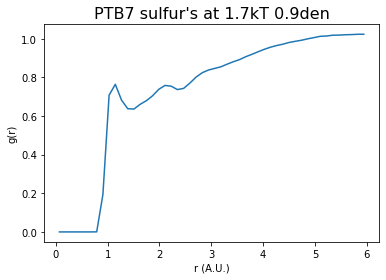

In [12]:
gsdfile = rdf_path
A_name = "ss"
B_name = "ss"
atom= "sulfur"
rdf = gsd_rdf(gsdfile, A_name, B_name, rmin=0.01, rmax=6)
plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (A.U.)")
plt.ylabel("g(r)")
plt.title("PTB7 %s's at %skT %sden" % (atom, job.sp['kT_reduced'], job.sp['density']), fontsize=16)
plt.show()

In [ ]:
def atom_type_pos(frame, atom_types): 
    positions = []
    for idx, type_id in enumerate(frame.particles.typeid):
        if frame.particles.types[type_id] in atom_types:
            positions.append(frame.particles.position[idx])
    return positions

In [ ]:
def create_rdf(rdf_path,
               atom_types='all',
               r_max = None,
               r_min = 0.1,
               nbins = 50,
               start = 100):
    
    
    f = gsd.pygsd.GSDFile(open(rdf_path, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f) 
    if r_max is None:
        r_max = max(trajectory[-1].configuration.box[:3]) * 0.45 
    freud_rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
    for frame in trajectory[start:]:
        if atom_types == 'all':
            freud_rdf.compute(system=frame, reset=False)
        else:
            query_points = atom_type_pos(frame, atom_types)
            box = frame.configuration.box
            freud_rdf.compute(system=(box, query_points), reset = False)
        
 
    x = freud_rdf.bin_centers
    y = freud_rdf.rdf
    filename = job.fn('{}-trajectory.txt').format(atom_types[0])
    np.savetxt(filename, np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
    f.close()
    return freud_rdf, filename

In [ ]:
#mess around with this ???

#for job in job_list:
#    rdf_path = job.fn("trajectory.gsd")
#    #print (rdf_path)
#    freud_rdf, filename = create_rdf(rdf_path, atom_types=['f'], start = 95)
#    txt_path = '{}-trajectory.txt'.format(atom_types[0])
#    #print(txt_path)

In [ ]:
def rdf_plot(job_list): 
    
    for job in job_list:
        rdf_path = job.fn("trajectory.gsd")
        freud_rdf, filename = create_rdf(rdf_path, atom_types=['f'], start = 95)
        txt_path = job.fn('f-trajectory.txt')

    line = np.genfromtxt(txt_path, names = True, delimiter = ",") 

    x = line["bin_centers"]
    y = line["rdf"]
    
    plt.plot(x, y, color = '#ffc08a')

    plt.xlabel("r")
    plt.ylabel("g(r)")
    plt.ylim(0, 1.6)
    plt.title(state_dict)

    
    plt.show()
    
    #still looking for atom type in title

In [ ]:
rdf_plot(job_list)

In [ ]:
   ymax = max(y)
    n_max = y.argmax()
    plt.plot(x[n_max],y[n_max],'o')
    n_min = y.argmin() 
    plt.plot(x[n_min],y[n_min],'x')

    #unsure how many decimals?
    plt.annotate("local max {}".format("%10.5f"% y[n_max]), xy=(x[n_max],y[n_max]), xytext=(x[n_max]+15,y[n_max]+15), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

    print("max is:" "%10.5f"% y[n_max]) 